# UCR dataset
* Download the zipped data [here](http://www.cs.ucr.edu/~eamonn/time_series_data/UCR_TS_Archive_2015.zip)
* Password to unzip: `attempttopredict`

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches, colors
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [12]:
# Debugger
from IPython.core.debugger import Pdb
t = Pdb().set_trace

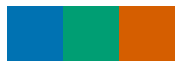

In [13]:
# Seaborn settings for nice plots
sns.set_style('dark')
colors_example = sns.color_palette('colorblind', 3)
sns.palplot(colors_example)

In [14]:
# Utility functions to generate time series data
np.random.seed(22)

def generate_data(period, num_series, num_points, var):
    t = np.linspace(0, num_points/2, num_points)
    random_means = np.random.rand(num_series, num_points) # a random mean for each serie
    random_var = var * np.random.randn(num_series, 1)
    data = random_means + random_var + np.sin(t * period)
    return data
    

def generate_series(num_labels, num_series_per_label, num_points_per_series):
    var = 0.5
    dfs = []
    for label in range(num_labels):
        period = label + 1
        data = generate_data(period, num_series_per_label, num_points_per_series, var)
        df = pd.DataFrame(data=data, columns=['t%s' % i for i in range(len(data[0]))])
        labels = np.zeros(num_series_per_label, dtype=int)
        labels.fill(label)
        df['label'] = labels
        dfs.append(df)
    return pd.concat(dfs)

In [15]:
# Utility function to reshape a dataframe
def reshape_df(df, max_rows, max_columns):
    if max_columns is not None:
        columns = list(df.columns.values)[:max_columns-1]
        if 'label' not in columns: columns.append('label')
        df = df.loc[:, columns]
    
    if max_rows is not None:
        df = df.iloc[:max_rows]

    return df

In [53]:
# Utility function to plot groups of time series
def plot_df(df, title=None, size=1):
    
    label_names = df.label.unique()
    for label in label_names:
        data = df.loc[df.label==label, df.columns.values != 'label'].values
            
        if len(data) == 1: # If there is only one time series, there's no point to plot uncertainty across series.
            plot_uncertainty = False
        else:
            plot_uncertainty = True
        
        if plot_uncertainty:
            f, ax = plt.subplots(2, figsize=(20,5 * size))
            # Plot all series
            for series in data:
                ax[0].plot(series)
            ax[0].set_xlim(0, len(series) -1)

            # Show confidence / uncertainty across all series 
            sns.tsplot(data=data, ax=ax[1])

            ax[1].set_ylabel('Uncertainty')
            if title is not None:
                ax[0].set_ylabel(title)
        else:
            f, ax = plt.subplots(1, figsize=(20,5 * size))

            # Plot all series
            for series in data:
                ax.plot(series)
            ax.set_xlim(0, len(series) -1)
            if title is not None:
                ax.set_ylabel(title)



# Utility functions plot timeseries with color patches.
# Useful for timeseries with labels.
# Note on how to draw rectangles with mpl: http://matthiaseisen.com/pp/patterns/p0203 
def plot_df_labels(df, name):
    """
    Plot data, hihglight each label in different colors, and add a legend.
    
    :param df: (pd.DataFrame) data to plot. Must contain a 'label' column.
    :param name: (str) name of the plot.
    """
    # Label IDs and color palette
    label_names = sorted(df.label.unique())
    palette = sns.color_palette('colorblind', len(label_names))  
    
    # Plot color palette legend
    plot_palette_legend(palette, label_names, 'Labels of %s' %name, alpha=0.5, size=0.5)

    # Features
    columns = list(df.columns.values)
    if 'label' in columns: columns.remove('label')
    nb_columns = len(columns)
    
    # Plot data
    fig, ax = plt.subplots(nrows=nb_columns, ncols=1, 
                           figsize=(20, nb_columns* 2))
    
    for i in range(nb_columns):
        column_name = columns[i]
        values = df[column_name].values
        labels = df.label.values
        ax[i].plot(values)
        add_patches(ax[i], values, labels, label_names, palette, alpha=0.5)
        ax[i].set_ylabel(column_name)
    plt.tight_layout()
    

def plot_palette_legend(palette, label_names, title, alpha=0.5, size=0.5):
    """
    Plot the values in a color palette as a horizontal array.

    palette: sequence of matplotlib colors as returned by seaborn.color_palette()
    size: scaling factor for size of plot
    """
    n = len(palette)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              alpha=alpha,
              cmap=colors.ListedColormap(palette),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(label_names)
    ax.set_yticklabels([])
    ax.set_title(title, loc='left')


def add_patches(ax, values, labels, label_ids, palette, alpha=0.5):
    """
    Highlight each label with different color patches.
    """
    minval = min(values)
    maxval = max(values) 
    ax.set_xlim(0, len(values)-1)
    ax.set_ylim(minval, maxval)
    
    start = 0
    curr_label = labels[0]
    # Print patches when the label changes
    for t in range(len(values)):
        label = labels[t]
        if label != curr_label:
            end = t
            color_idx = label_ids.index(curr_label)
            color = palette[color_idx]
            ax.add_patch(patches.Rectangle((start, minval), # (x, y)
                                            end-start, # width
                                            maxval-minval, # height
                                            alpha=alpha, 
                                            color=color))
            start = end
            curr_label = label

    # Print the last patch
    end = t
    color_idx = label_ids.index(curr_label)
    color = palette[color_idx]
    ax.add_patch(patches.Rectangle((start, minval), # (x, y)
                                    end-start, # width
                                    maxval-minval, # height
                                    alpha=alpha, 
                                    color=color))

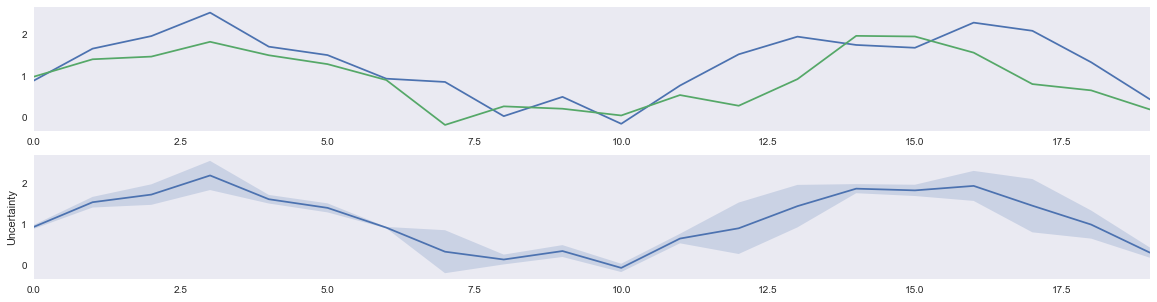

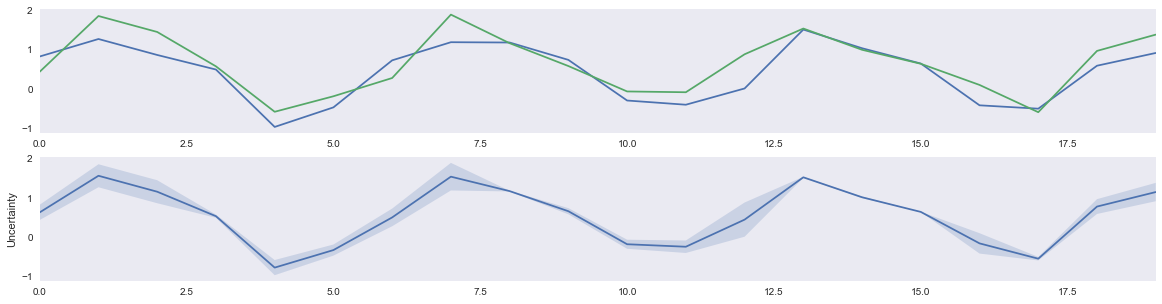

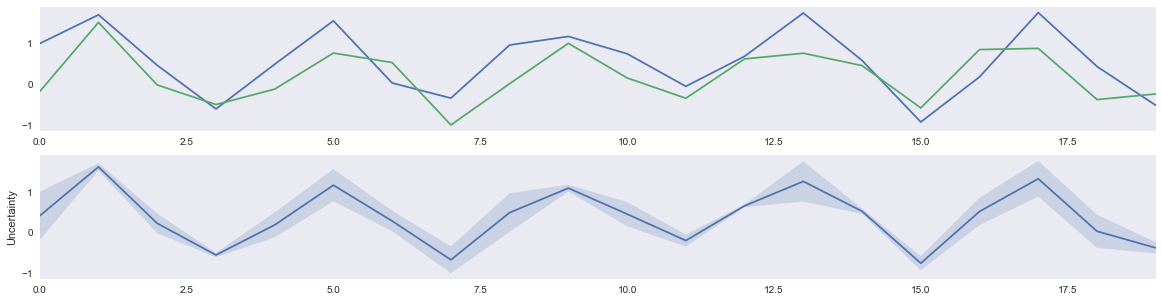

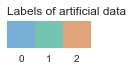

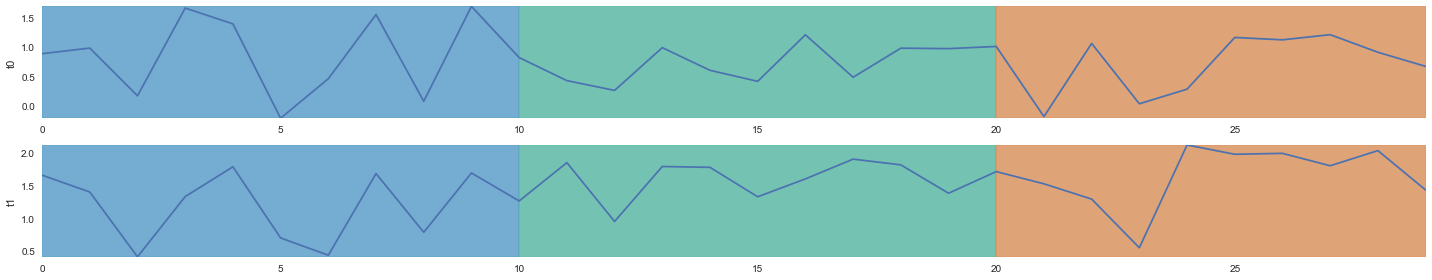

In [21]:
# Example with artificial data
num_labels = 3   
num_series_per_label = 10
num_points_per_series = 20
df = generate_series(num_labels, num_series_per_label, num_points_per_series)

max_rows = 2
max_columns = None
for label in df.label.unique():
    df2 = reshape_df(df[df.label == label], max_rows, max_columns)
    plot_df(df2)
    
max_rows = None
max_columns = 3
df1 = reshape_df(df, max_rows, max_columns)
plot_df_labels(df1, 'artificial data')


In [22]:
# Util functions to load a UCR dataset
def load(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = ['label'] + ['t%s' % i for i in range(len(df.columns) - 1)]
    return df

def get_dataset_names(datasets_dir):
    dataset_names = []
    for root, dirs, files in os.walk(datasets_dir):
        for name in dirs:
            if name[0] != '.': # ignore cached files
                dataset_names.append(name)
    return dataset_names

In [23]:
# Load a UCR dataset 
phase = 'train'

datasets_dir = "UCR_TS_Archive_2015"
#dataset_names = get_dataset_names(datasets_dir)
dataset_name = 'synthetic_control'
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase.upper()))
print 'input csv:', input_csv_path
df = load(input_csv_path)
print 'csv loaded:', input_csv_path
print 'data shape:', df.shape
print df.columns.values

input csv: UCR_TS_Archive_2015/synthetic_control/synthetic_control_TRAIN
csv loaded: UCR_TS_Archive_2015/synthetic_control/synthetic_control_TRAIN
data shape: (299, 61)
['label' 't0' 't1' 't2' 't3' 't4' 't5' 't6' 't7' 't8' 't9' 't10' 't11'
 't12' 't13' 't14' 't15' 't16' 't17' 't18' 't19' 't20' 't21' 't22' 't23'
 't24' 't25' 't26' 't27' 't28' 't29' 't30' 't31' 't32' 't33' 't34' 't35'
 't36' 't37' 't38' 't39' 't40' 't41' 't42' 't43' 't44' 't45' 't46' 't47'
 't48' 't49' 't50' 't51' 't52' 't53' 't54' 't55' 't56' 't57' 't58' 't59']


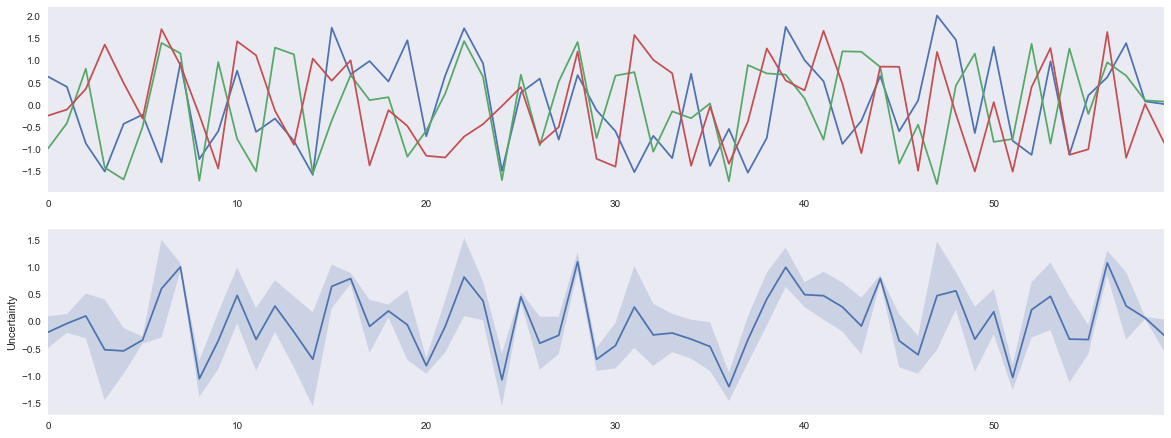

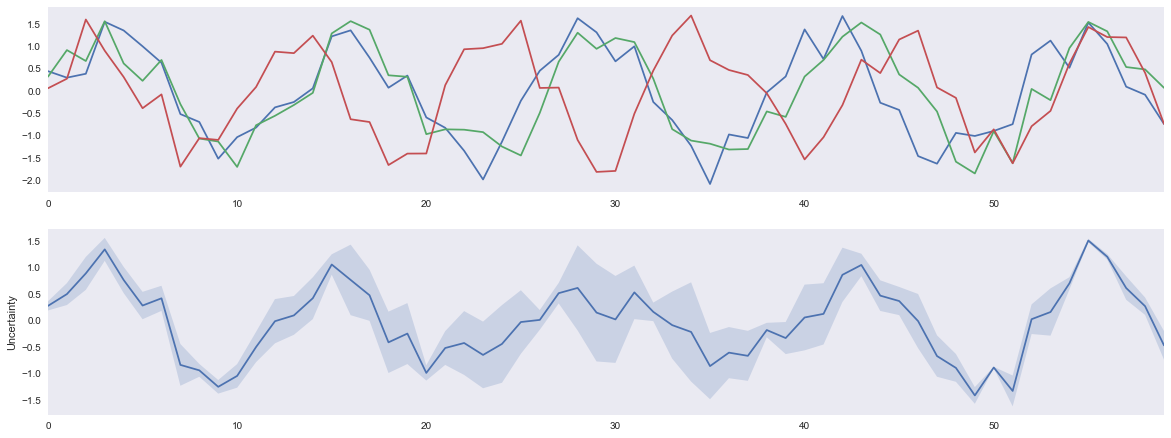

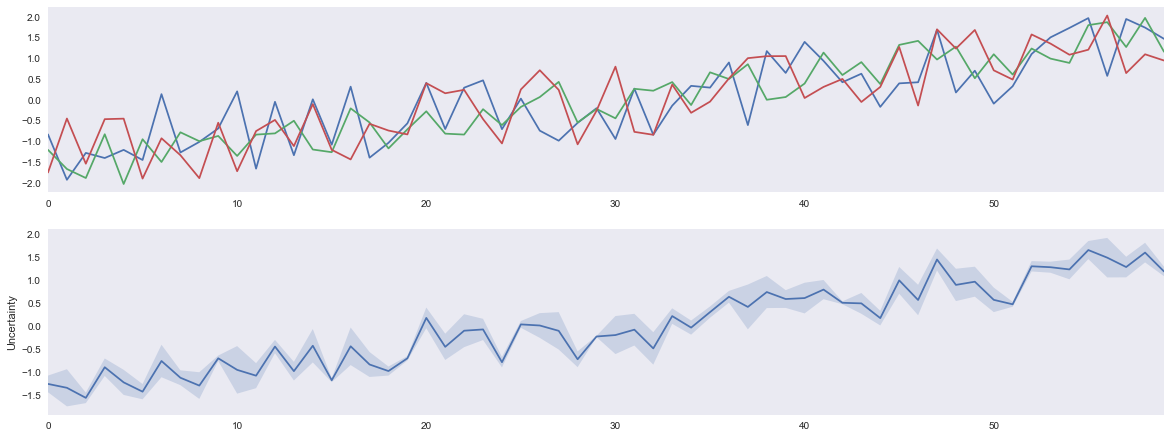

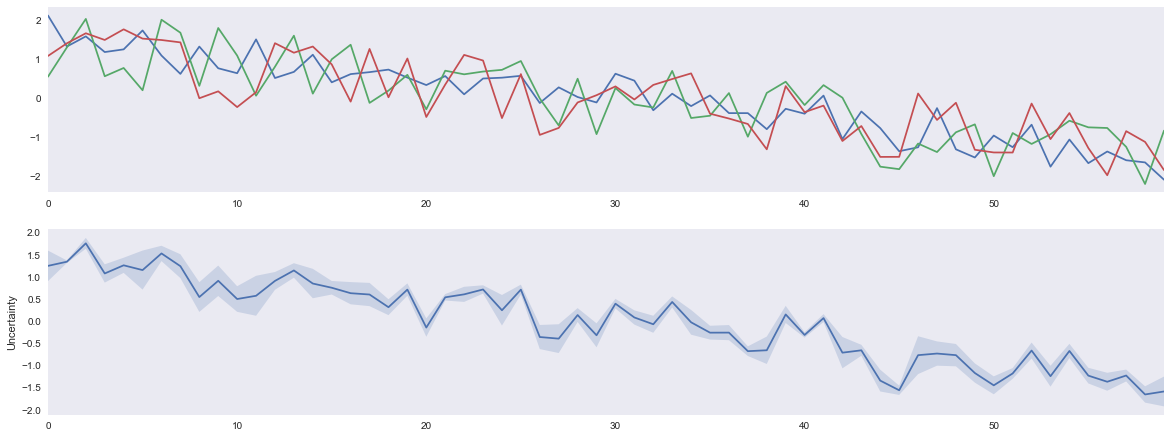

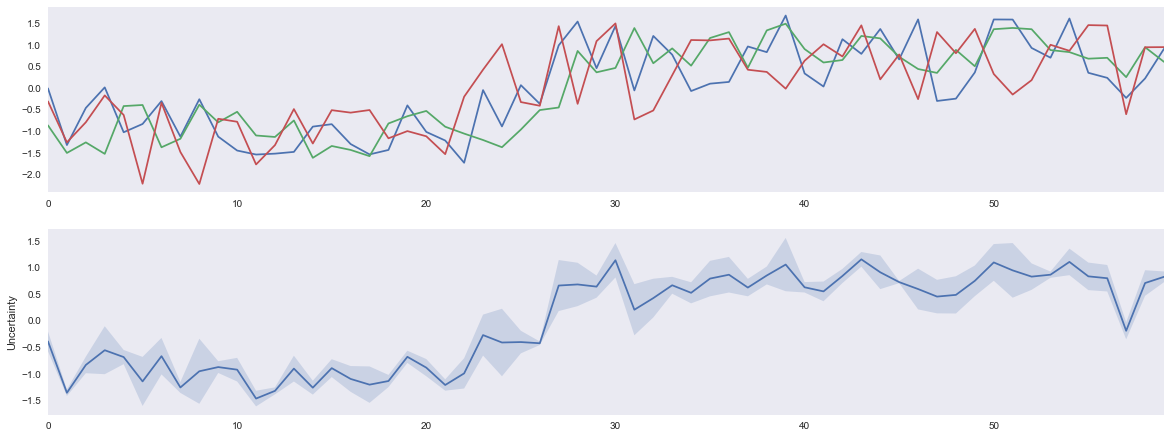

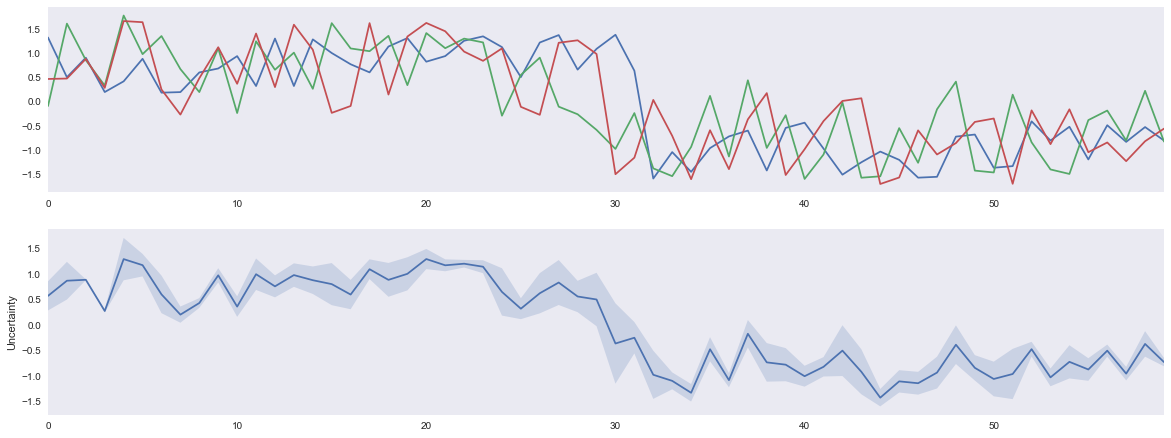

In [24]:
# Plot dataset
max_rows = 3
max_columns = None
for label in df.label.unique():
    df2 = reshape_df(df[df.label == label], max_rows, max_columns)
    plot_df(df2, size=1.5)

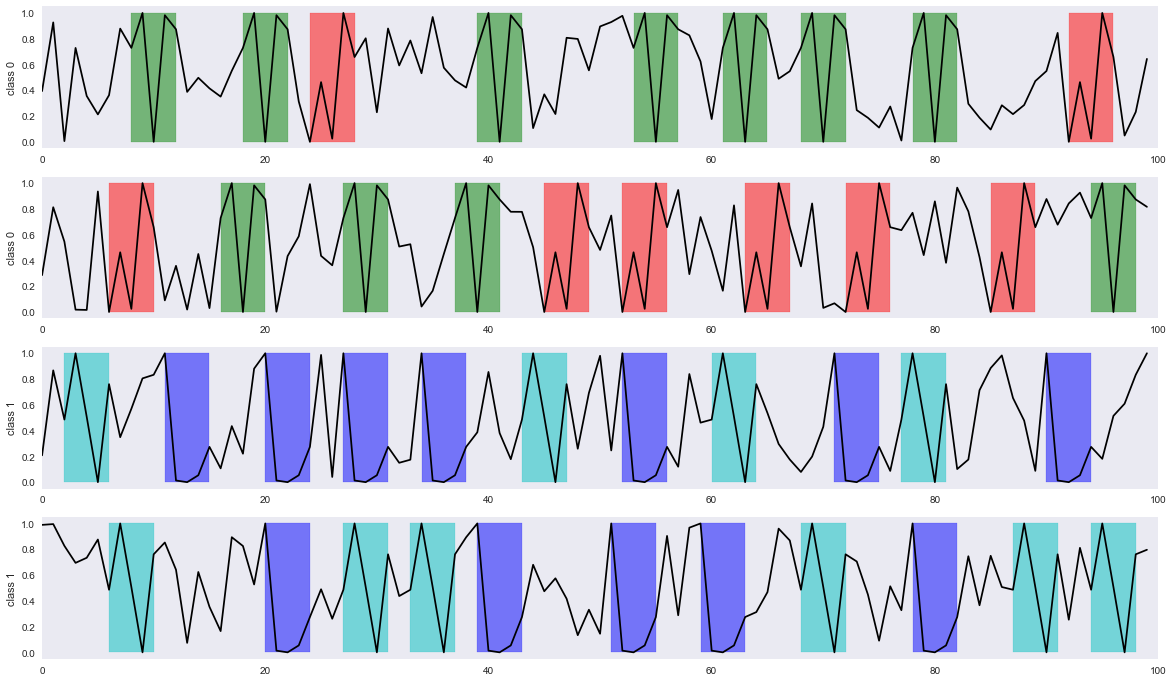

In [25]:
% run generate_synthetic_data.py

# Health check to make sure the values are loaded well with pandas
data = np.loadtxt(os.path.join('SyntheticData', 'Test1','Test1_TRAIN'),  delimiter=',')[1:,]

phase = 'TRAIN'
datasets_dir = "SyntheticData"
dataset_name = 'Test1'
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase))

df = load(input_csv_path)
assert (np.isclose(data[:,0], df[df.columns.values[0]])).all()
assert (np.isclose(data[:,1], df[df.columns.values[1]])).all()

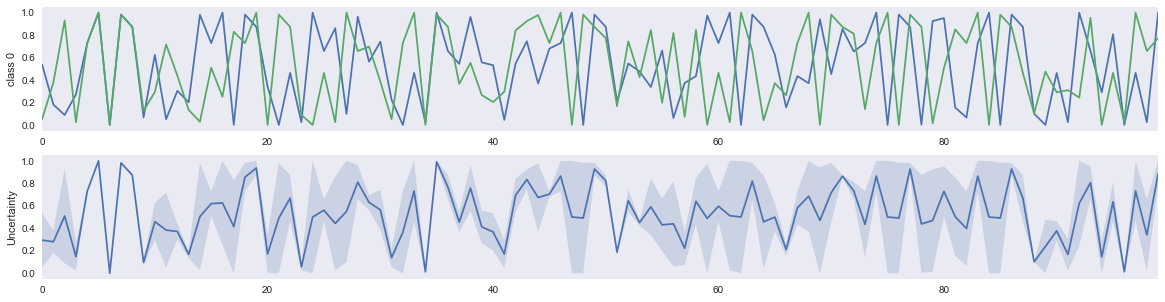

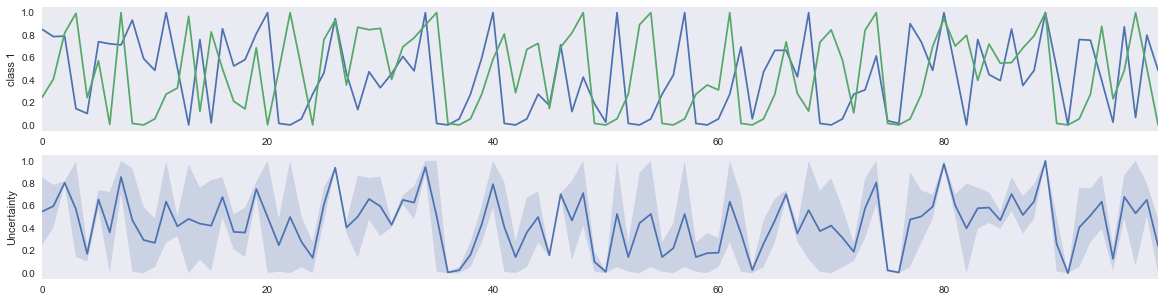

In [31]:
# Example with synthetic data
phase = 'TRAIN'
datasets_dir = "SyntheticData"
dataset_name = 'Test1'
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase))
df = load(input_csv_path)

max_rows = 2
max_columns = None
for label in df.label.unique():
    df2 = reshape_df(df[df.label == label], max_rows, max_columns)
    plot_df(df2, 'class %s' % int(label))

In [51]:
%run ../capybara/datasets/uci_har/convert_to_sequences.py -i ../capybara/datasets/uci_har -c 500

# Load a converted UCI dataset 
phase = 'train'
datasets_dir = "inertial_signals"
dataset_name = 'body_acc_x'
input_csv_path = os.path.join(datasets_dir, dataset_name, '%s_%s' % (dataset_name, phase.upper()))
print 'input csv:', input_csv_path
df3 = load(input_csv_path)
print 'csv loaded:', input_csv_path
print 'data shape:', df3.shape
print 'labels', df3.label.unique()

Path to converted files: inertial_signals/
Path to converted files: debug/
input csv: inertial_signals/body_acc_x/body_acc_x_TRAIN
csv loaded: inertial_signals/body_acc_x/body_acc_x_TRAIN
data shape: (17, 501)
labels [ 0.  1.]


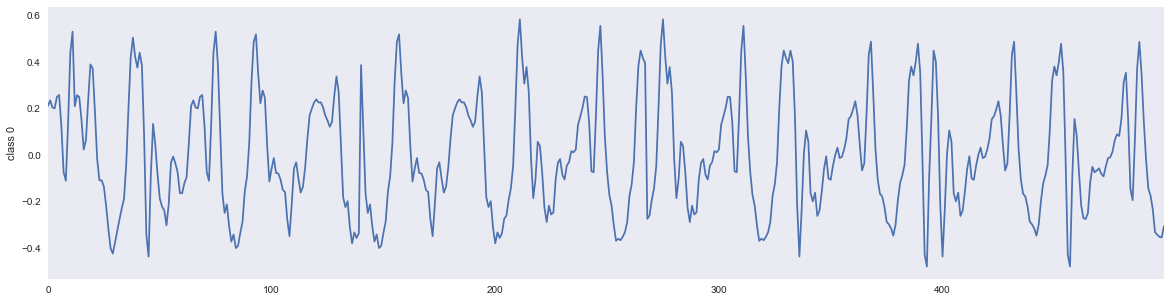

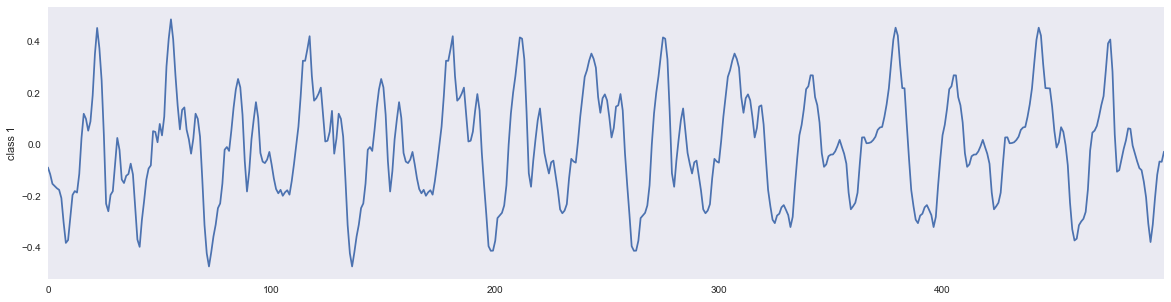

In [62]:
max_rows = 1
max_columns = None
for label in df.label.unique():
    df4 = reshape_df(df3[df3.label == label], max_rows, max_columns)
    title = 'class %s' % int(label)
    plot_df(df4, title=title, size=1)